# Imports

In [1]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

# Dataset

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete4Z4L2N/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete4Z4L2N/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete4Z4L2N/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

# Preprocess

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [6]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [7]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"I saw this movie with my dad. I must have been pretty young, around 15. It was on Star Movies one afternoon.The movie started a bit vaguely, but you could tell those robbers were gathering up for a score. It really caught pace after the first half hour.<br /><br />All the actors are great, especially Blades and Lou Diamond. I Guess it's the ensemble, they just play so well together. I can watch this film anytime.I think it is the relative stupidity of the plot and the characters trying to deal with a very weird score. The jokes are not corny but they are subtle and extreme at the same time that make them so hilarious.<br /><br />A perfect comedy for a lazy afternoon."
 b"Well, no, not really. Its not really a good movie, but its not as bad as I thought it was going to be. I really didn't feel ripped off of my rental money, and sometimes thats all you can ask for. The plot is OK, nothing brilliant or new, the acting is pretty bad, but the cast is pretty. The directing is pass

In [8]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [9]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [10]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 10, 208,  11, ...,   0,   0,   0],
       [ 74,  57,  22, ...,   0,   0,   0],
       [ 11,   7,  29, ...,   0,   0,   0]])

In [11]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"I saw this movie with my dad. I must have been pretty young, around 15. It was on Star Movies one afternoon.The movie started a bit vaguely, but you could tell those robbers were gathering up for a score. It really caught pace after the first half hour.<br /><br />All the actors are great, especially Blades and Lou Diamond. I Guess it's the ensemble, they just play so well together. I can watch this film anytime.I think it is the relative stupidity of the plot and the characters trying to deal with a very weird score. The jokes are not corny but they are subtle and extreme at the same time that make them so hilarious.<br /><br />A perfect comedy for a lazy afternoon."
Round-trip:  i saw this movie with my [UNK] i must have been pretty young around [UNK] it was on star movies one [UNK] movie started a bit [UNK] but you could tell those [UNK] were [UNK] up for a score it really [UNK] [UNK] after the first half [UNK] br all the actors are great especially [UNK] and [UNK] [UNK

# Model 1

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 50s 106ms/step - loss: 0.6802 - accuracy: 0.5200 - val_loss: 0.4640 - val_accuracy: 0.8068
Epoch 2/10
391/391 [==============================] - 40s 99ms/step - loss: 0.4414 - accuracy: 0.8006 - val_loss: 0.3777 - val_accuracy: 0.8208
Epoch 3/10
391/391 [==============================] - 39s 99ms/step - loss: 0.3518 - accuracy: 0.8483 - val_loss: 0.3413 - val_accuracy: 0.8464
Epoch 4/10
391/391 [==============================] - 39s 98ms/step - loss: 0.3261 - accuracy: 0.8598 - val_loss: 0.3326 - val_accuracy: 0.8521
Epoch 5/10
391/391 [==============================] - 39s 98ms/step - loss: 0.3139 - accuracy: 0.8660 - val_loss: 0.3266 - val_accuracy: 0.8547
Epoch 6/10
391/391 [==============================] - 39s 97ms/step - loss: 0.3063 - accuracy: 0.8699 - val_loss: 0.3270 - val_accuracy: 0.8547
Epoch 7/10
391/391 [==============================] - 39s 98ms/step - loss: 0.3029 - accuracy: 0.8731 - val_loss: 0.3239 - val_accuracy

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 18s 45ms/step - loss: 0.3316 - accuracy: 0.8610
Test Loss: 0.3315992057323456
Test Accuracy: 0.8610399961471558


(0.0, 0.6503445848822593)

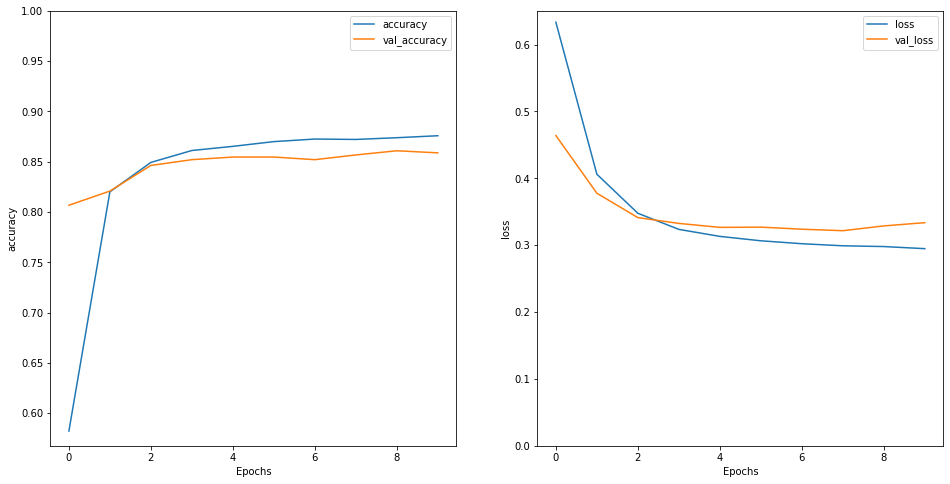

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

# Model 2

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 92s 182ms/step - loss: 0.6683 - accuracy: 0.5352 - val_loss: 0.4351 - val_accuracy: 0.7927
Epoch 2/10
391/391 [==============================] - 67s 171ms/step - loss: 0.4085 - accuracy: 0.8176 - val_loss: 0.3508 - val_accuracy: 0.8469
Epoch 3/10
391/391 [==============================] - 67s 169ms/step - loss: 0.3404 - accuracy: 0.8553 - val_loss: 0.3318 - val_accuracy: 0.8583
Epoch 4/10
391/391 [==============================] - 67s 171ms/step - loss: 0.3209 - accuracy: 0.8625 - val_loss: 0.3234 - val_accuracy: 0.8635
Epoch 5/10
391/391 [==============================] - 67s 171ms/step - loss: 0.3146 - accuracy: 0.8653 - val_loss: 0.3246 - val_accuracy: 0.8490
Epoch 6/10
391/391 [==============================] - 67s 170ms/step - loss: 0.3038 - accuracy: 0.8712 - val_loss: 0.3293 - val_accuracy: 0.8641
Epoch 7/10
391/391 [==============================] - 67s 170ms/step - loss: 0.3067 - accuracy: 0.8717 - val_loss: 0.3366 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 31s 78ms/step - loss: 0.3418 - accuracy: 0.8620
Test Loss: 0.34184888005256653
Test Accuracy: 0.8619999885559082


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[-2.0051959]]


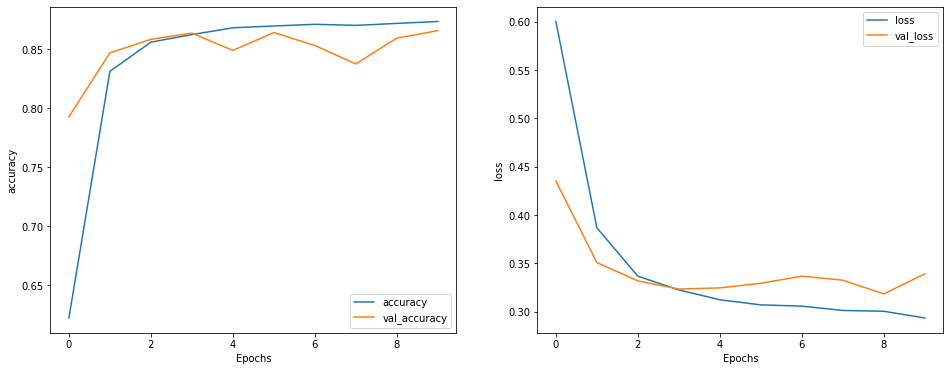

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# Model 3

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 48s 93ms/step - loss: 0.6921 - accuracy: 0.5022 - val_loss: 0.6066 - val_accuracy: 0.6062
Epoch 2/10
391/391 [==============================] - 35s 89ms/step - loss: 0.5167 - accuracy: 0.7311 - val_loss: 0.3842 - val_accuracy: 0.8422
Epoch 3/10
391/391 [==============================] - 35s 89ms/step - loss: 0.3678 - accuracy: 0.8428 - val_loss: 0.3490 - val_accuracy: 0.8344
Epoch 4/10
391/391 [==============================] - 36s 89ms/step - loss: 0.3425 - accuracy: 0.8538 - val_loss: 0.3379 - val_accuracy: 0.8578
Epoch 5/10
391/391 [==============================] - 35s 89ms/step - loss: 0.3302 - accuracy: 0.8635 - val_loss: 0.3263 - val_accuracy: 0.8568
Epoch 6/10
391/391 [==============================] - 36s 89ms/step - loss: 0.3261 - accuracy: 0.8652 - val_loss: 0.3338 - val_accuracy: 0.8427
Epoch 7/10
391/391 [==============================] - 36s 89ms/step - loss: 0.3199 - accuracy: 0.8679 - val_loss: 0.3223 - val_accuracy:

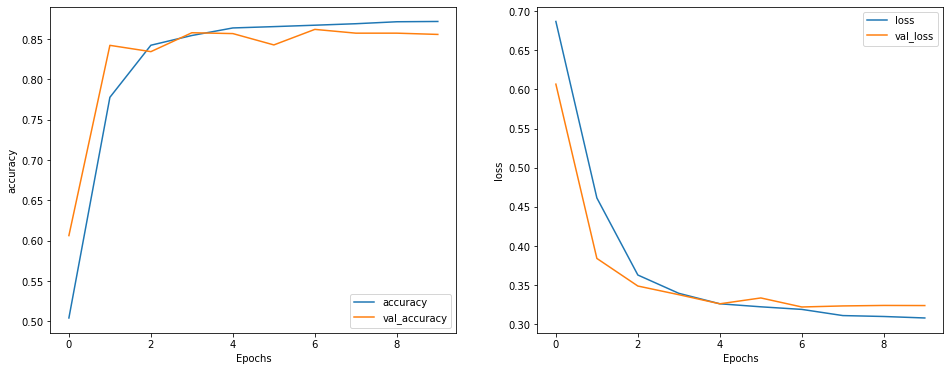

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# Model 4

Epoch 1/10
391/391 [==============================] - 96s 190ms/step - loss: 0.6661 - accuracy: 0.5365 - val_loss: 0.4096 - val_accuracy: 0.8208
Epoch 2/10
391/391 [==============================] - 70s 178ms/step - loss: 0.3919 - accuracy: 0.8222 - val_loss: 0.3440 - val_accuracy: 0.8510
Epoch 3/10
391/391 [==============================] - 71s 179ms/step - loss: 0.3337 - accuracy: 0.8562 - val_loss: 0.3326 - val_accuracy: 0.8573
Epoch 4/10
391/391 [==============================] - 70s 178ms/step - loss: 0.3231 - accuracy: 0.8588 - val_loss: 0.3256 - val_accuracy: 0.8615
Epoch 5/10
391/391 [==============================] - 71s 179ms/step - loss: 0.3117 - accuracy: 0.8630 - val_loss: 0.3178 - val_accuracy: 0.8505
Epoch 6/10
391/391 [==============================] - 71s 179ms/step - loss: 0.2972 - accuracy: 0.8706 - val_loss: 0.3424 - val_accuracy: 0.8406
Epoch 7/10
391/391 [==============================] - 70s 179ms/step - loss: 0.3001 - accuracy: 0.8673 - val_loss: 0.3151 - val_ac

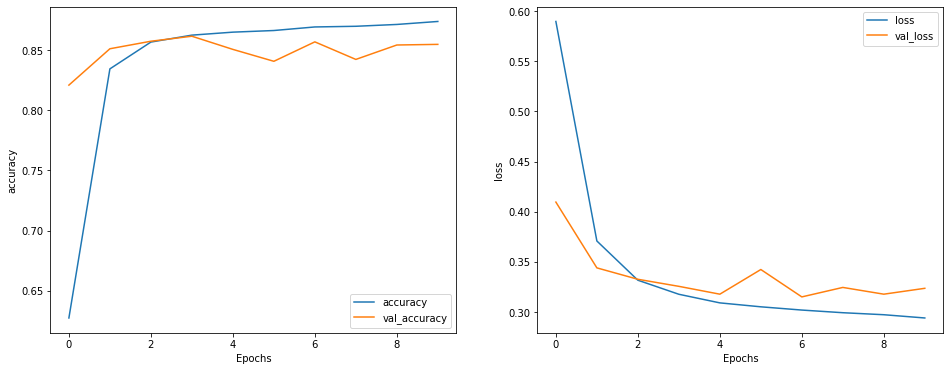

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# Model 5

Epoch 1/10
391/391 [==============================] - 84s 115ms/step - loss: 0.6725 - accuracy: 0.5198 - val_loss: 0.4247 - val_accuracy: 0.8057
Epoch 2/10
391/391 [==============================] - 42s 106ms/step - loss: 0.3893 - accuracy: 0.8245 - val_loss: 0.3477 - val_accuracy: 0.8432
Epoch 3/10
391/391 [==============================] - 42s 106ms/step - loss: 0.3256 - accuracy: 0.8577 - val_loss: 0.3326 - val_accuracy: 0.8521
Epoch 4/10
391/391 [==============================] - 42s 106ms/step - loss: 0.3153 - accuracy: 0.8626 - val_loss: 0.3292 - val_accuracy: 0.8469
Epoch 5/10
391/391 [==============================] - 42s 106ms/step - loss: 0.3066 - accuracy: 0.8686 - val_loss: 0.3241 - val_accuracy: 0.8589
Epoch 6/10
391/391 [==============================] - 42s 106ms/step - loss: 0.3061 - accuracy: 0.8697 - val_loss: 0.3216 - val_accuracy: 0.8484
Epoch 7/10
391/391 [==============================] - 42s 106ms/step - loss: 0.3026 - accuracy: 0.8701 - val_loss: 0.3317 - val_ac

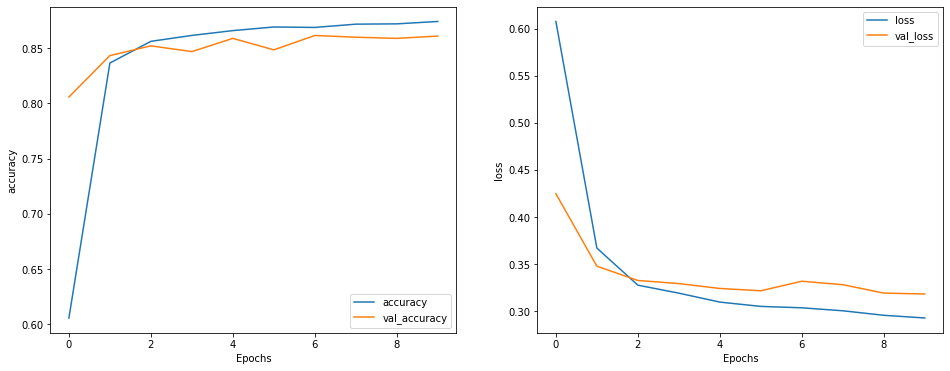

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=128,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# Model 6

Epoch 1/10
391/391 [==============================] - 49s 98ms/step - loss: 0.6859 - accuracy: 0.5145 - val_loss: 0.5167 - val_accuracy: 0.7286
Epoch 2/10
391/391 [==============================] - 36s 91ms/step - loss: 0.5279 - accuracy: 0.7197 - val_loss: 0.4397 - val_accuracy: 0.7802
Epoch 3/10
391/391 [==============================] - 36s 91ms/step - loss: 0.4156 - accuracy: 0.8121 - val_loss: 0.3957 - val_accuracy: 0.8240
Epoch 4/10
391/391 [==============================] - 36s 90ms/step - loss: 0.3668 - accuracy: 0.8377 - val_loss: 0.3607 - val_accuracy: 0.8380
Epoch 5/10
391/391 [==============================] - 36s 91ms/step - loss: 0.3410 - accuracy: 0.8510 - val_loss: 0.3431 - val_accuracy: 0.8396
Epoch 6/10
391/391 [==============================] - 36s 90ms/step - loss: 0.3309 - accuracy: 0.8562 - val_loss: 0.3406 - val_accuracy: 0.8604
Epoch 7/10
391/391 [==============================] - 36s 91ms/step - loss: 0.3231 - accuracy: 0.8634 - val_loss: 0.3233 - val_accuracy:

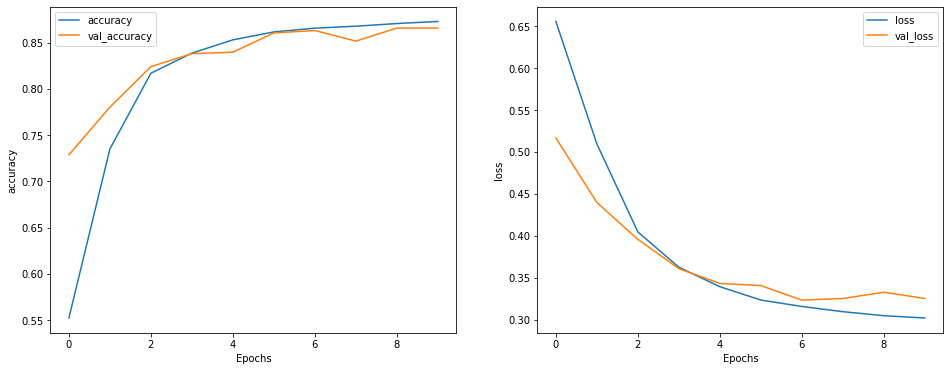

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# Model 7

Epoch 1/10
391/391 [==============================] - 49s 96ms/step - loss: 0.6886 - accuracy: 0.5003 - val_loss: 0.5675 - val_accuracy: 0.6083
Epoch 2/10
391/391 [==============================] - 35s 89ms/step - loss: 0.5249 - accuracy: 0.7013 - val_loss: 0.4516 - val_accuracy: 0.8047
Epoch 3/10
391/391 [==============================] - 35s 89ms/step - loss: 0.4603 - accuracy: 0.7817 - val_loss: 0.4364 - val_accuracy: 0.8234
Epoch 4/10
391/391 [==============================] - 35s 89ms/step - loss: 0.4197 - accuracy: 0.8222 - val_loss: 0.4229 - val_accuracy: 0.7656
Epoch 5/10
391/391 [==============================] - 36s 89ms/step - loss: 0.3750 - accuracy: 0.8317 - val_loss: 0.3568 - val_accuracy: 0.8484
Epoch 6/10
391/391 [==============================] - 35s 88ms/step - loss: 0.3479 - accuracy: 0.8469 - val_loss: 0.3452 - val_accuracy: 0.8557
Epoch 7/10
391/391 [==============================] - 35s 89ms/step - loss: 0.3378 - accuracy: 0.8571 - val_loss: 0.3340 - val_accuracy:

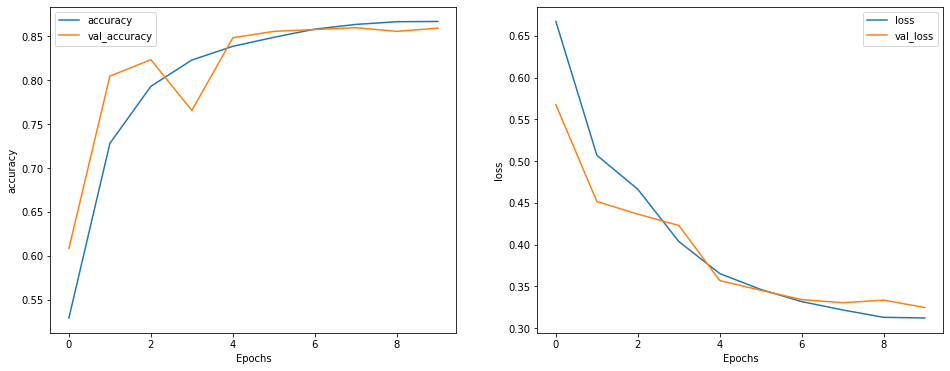

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=16,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# Model 8

Epoch 1/10
391/391 [==============================] - 49s 97ms/step - loss: 0.6915 - accuracy: 0.5023 - val_loss: 0.6185 - val_accuracy: 0.5526
Epoch 2/10
391/391 [==============================] - 36s 90ms/step - loss: 0.5956 - accuracy: 0.6581 - val_loss: 0.5517 - val_accuracy: 0.6943
Epoch 3/10
391/391 [==============================] - 36s 91ms/step - loss: 0.5145 - accuracy: 0.7338 - val_loss: 0.4810 - val_accuracy: 0.7505
Epoch 4/10
391/391 [==============================] - 36s 91ms/step - loss: 0.4688 - accuracy: 0.7605 - val_loss: 0.4063 - val_accuracy: 0.8083
Epoch 5/10
391/391 [==============================] - 36s 91ms/step - loss: 0.4008 - accuracy: 0.8056 - val_loss: 0.3831 - val_accuracy: 0.8302
Epoch 6/10
391/391 [==============================] - 36s 91ms/step - loss: 0.3929 - accuracy: 0.8207 - val_loss: 0.3833 - val_accuracy: 0.8391
Epoch 7/10
391/391 [==============================] - 36s 91ms/step - loss: 0.3656 - accuracy: 0.8346 - val_loss: 0.3651 - val_accuracy:

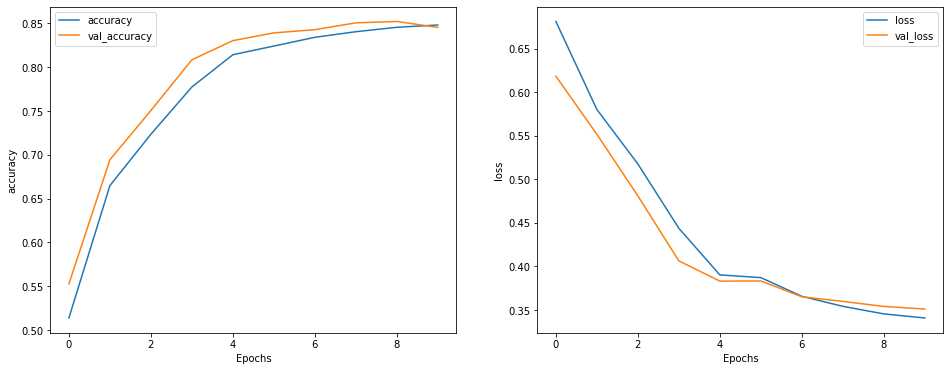

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=16,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')